# Experiment 3.1.2: Preprocessing of continuous variables

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import r2_score

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift
from captum.attr._utils.lrp_rules import EpsilonRule

from scipy.interpolate import interp1d

#### Method to generate the continuous data samples

In [2]:
def gen_data(num_features=12, num_samples=5000):

    mue = np.random.uniform(-2, 2, (num_features, 1))
    sigma = np.random.uniform(np.sqrt(0.9), np.sqrt(1.1), (num_features, 1))

    X = np.random.normal(mue, sigma, size=(num_features, num_samples)).T

    return X

#### Define the different transformation functions

In [3]:
def g(X, func):
    if func == "Linear":
        return X
    
    elif func == "Piece-wise linear":
        pw_x = np.array([
            -6.25, -5.75, -5.25, -4.75, -4.25, -3.75, -3.25, -2.75, -2.25, -1.75,
            -1.25, -0.75, -0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,
            3.75,  4.25,  4.75,  5.25,  5.75,  6.25
        ])

        pw_y = np.array([
            -0.25, -0.15, -1.05, -1.15, -2.05, -2.25, -2.6, -2.6, -2.25, -2.15,
            -1.25, -1.15, -0.25, -0.25, -1.15, -1.25, -2.15, -2.25, -2.6, -2.6,
            -2.25, -2.05, -1.15, -1.05, -0.15, -0.25
        ]) + 1.5

        pw_linear = interp1d(pw_x, pw_y, kind='linear', fill_value="extrapolate", bounds_error=False)

        return(pw_linear(X))
    
    elif func == "Non-continuous":
        X_proc = X.copy()
        for i in range(len(X)):
            for j in range(len(X[0])):
                if np.abs(X[i,j]) <= 1.5:
                    X_proc[i,j] = np.where(np.abs(X[i,j]) < 0.4, 1, -1)
                else:
                    X_proc[i,j] = np.sign(X[i,j]) * 0.05 * (X[i,j]**2 - 1.5**2) - 1
        return X_proc
        
    elif func == "Exponential":
        return np.exp(X)
    
    else:
        return X

#### Calculate the desired model output Y from the inputs

In [4]:
def calc_y(X, num_features, num_samples, func):

    epsilon = np.random.normal(0, 1, num_samples)

    beta = np.random.uniform(-5, 5, num_features + 1)
    beta[1:] = np.ones(num_features)

    Y = beta[0] + np.sum(np.multiply(beta[1:], g(X, func)), axis=1) + epsilon

    return Y, beta

#### Define the neural network

In [5]:
class Net(nn.Module):

    def __init__(self, num_features):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )
    
    def forward(self, input):
        return self.net(input)

#### Split the data into train and test set

In [6]:
def train_split(X, Y, num_samples, train_rate=0.8):
    index = int(num_samples * train_rate)

    X_train = X[:index]
    Y_train = Y[:index]

    X_test = X[index:]
    Y_test = Y[index:]

    return X_train, X_test, Y_train, Y_test

#### Define the different preprocessing techniques

In [7]:
def preprocess(X_train, X_test, type="No scaling"):
    if type == "Z-score":
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)

        X_train = (X_train - mean) / std
        X_test = (X_test - mean) / std

    elif type == "Max-abs":
        max_abs = np.max(np.absolute(X_train), axis=0)

        X_train = X_train / max_abs
        X_test = X_test / max_abs
    
    return X_train, X_test

#### Method to train the model

In [8]:
def train_model(net, X_train, X_test, Y_train, Y_test):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    highest_score = -10
    counter = 50
    PATH = "best_model_preproc_cont.pt"

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)

    for epoch in range(300):
        net.train()
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()
        
        r2 = r2_score(net.forward(torch.FloatTensor(X_test)), torch.FloatTensor(np.reshape(Y_test, (-1, 1))))

        if r2 > highest_score:
            highest_score = r2
            counter = 50
            torch.save(net.state_dict(), PATH)
        else:
            counter -= 1

        if counter == 0:
            break

    net.load_state_dict(torch.load(PATH, weights_only=True))
    net.eval()
        
    score = r2_score(net.forward(torch.FloatTensor(X_test)), torch.FloatTensor(np.reshape(Y_test, (-1, 1))))

    return net, score

#### Generate the attribution values

In [9]:
def calc_explanations(X_test, net):

    test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)

    test_input_tensor.requires_grad_()

    #Gradient

    sal = Saliency(net)

    attr_grad = sal.attribute(test_input_tensor, abs=False)
    attr_grad = attr_grad.detach().numpy()

    #SmoothGrad

    sal = Saliency(net)
    nt = NoiseTunnel(sal)

    noise_level = 0.2
    stdev = (torch.max(test_input_tensor) - torch.min(test_input_tensor)).detach().item() * noise_level

    attr_sm_grad = nt.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev, abs=False)
    attr_sm_grad = attr_sm_grad.detach().numpy()

    #Saliency

    attr_sal = np.square(attr_grad)

    #InputXGradient

    ixg = InputXGradient(net)

    attr_ixg = ixg.attribute(test_input_tensor)
    attr_ixg = attr_ixg.detach().numpy()

    #LRP-Epsilon

    net.net.rule = EpsilonRule(0.1)

    lrp = LRP(net)

    attr_lrp = lrp.attribute(test_input_tensor)
    attr_lrp = attr_lrp.detach().numpy()

    #SmoothGradXInput

    ixg = InputXGradient(net)
    nt_ixg = NoiseTunnel(ixg)

    attr_sm_ixg = nt_ixg.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev)
    attr_sm_ixg = attr_sm_ixg.detach().numpy()

    #Integrated Gradients

    ig = IntegratedGradients(net)

    attr_ig_zero = ig.attribute(test_input_tensor,baselines=0.0)
    attr_ig_zero = attr_ig_zero.detach().numpy()


    baseline_mean = torch.mean(torch.from_numpy(X_test), dim=0, keepdim=True).type(torch.FloatTensor)

    ig = IntegratedGradients(net)

    attr_ig_mean = ig.attribute(test_input_tensor,baselines=baseline_mean)
    attr_ig_mean = attr_ig_mean.detach().numpy()

    #DeepLIFT

    dl = DeepLift(net)

    attr_dl_zero = dl.attribute(test_input_tensor, baselines=0.0)
    attr_dl_zero = attr_dl_zero.detach().numpy()

    dl = DeepLift(net)

    attr_dl_mean = dl.attribute(test_input_tensor, baselines=baseline_mean)
    attr_dl_mean = attr_dl_mean.detach().numpy()

    return attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean

#### Method to calculate the correlation between the attributions and the ground truth feature importance

In [10]:
def correlations(attr, feature_importance, num_features):
    
    explainations = attr.T

    corr_matrix = np.corrcoef(feature_importance, explainations)

    corr = [corr_matrix[i, num_features + i] for i in range(num_features)]

    return corr

#### Method to print the mean and standard deviation of correlation values

In [11]:
def print_mean_std(corr, label, p=True):
    corr = np.array(corr)
    if p:
        print(f"{label}: Mean = {np.mean(corr)}, Std = {np.std(corr)}")
    return np.mean(corr), np.std(corr)

#### Method to calculate the ground truth feature importances from the input features

In [12]:
def calc_feature_importance(X_test, beta, func):
    feature_importance = np.multiply(beta[1:], g(X_test, func)).T

    return feature_importance

#### Main method to run the simulation

In [13]:
num_features = 12
num_samples = 5000

methods = ["Gradient", "Smooth Grad", "Saliency", "LRP-ℇ", "GradiientxInput/LRP-0", "SmoothGradxInput", "Integrated Gradients (zero)",
                                    "Integrated Gradients (mean)", "DeepLift (zero)", "DeepLift (mean)"]

preprocessing = []

mean_vals = np.random.uniform(-1, 1, (len(methods), 12))
std_vals = np.random.uniform(0.1, 0.6, (len(methods), 12))

j = 0

for func in ["Linear", "Piece-wise linear", "Non-continuous", "Exponential"]:
   
   for type in ["No scaling", "Z-score", "Max-abs"]:
      
      preprocessing.append(f"{func}, {type}")
      
      print(f"\nFunction: {func}, Preprocessing: {type} \n")

      net_scores = []

      corr_grad, corr_sm_grad, corr_sal, corr_ixg, corr_lrp, corr_sm_ixg, corr_ig_zero, corr_ig_mean, corr_dl_zero, corr_dl_mean = [], [], [], [], [], [], [], [], [], []
      
      for _ in range(200): #200

        X = gen_data(num_features, num_samples)

        Y, beta = calc_y(X, num_features, num_samples, func=func)

        net = Net(num_features)

        X_train, X_test, Y_train, Y_test = train_split(X, Y, num_samples)

        feature_importance = calc_feature_importance(X_test, beta, func)

        X_train, X_test = preprocess(X_train, X_test, type=type)

        net, score = train_model(net, X_train, X_test, Y_train, Y_test)

        net_scores.append(score)

        #print(f"Net R2 Score: {score}")

        attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean = calc_explanations(X_test, net)

        for (attr, corr) in zip(
            (attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean),
            (corr_grad, corr_sm_grad, corr_sal, corr_ixg, corr_lrp, corr_sm_ixg, corr_ig_zero, corr_ig_mean, corr_dl_zero, corr_dl_mean)
            ):
                    
            corr.extend(correlations(attr, feature_importance, num_features))

      print_mean_std(net_scores, "Net R2 Score")
      print()

      for (i, corr, name) in zip(range(len(methods)),
                        (corr_grad, corr_sm_grad, corr_sal, corr_lrp, corr_ixg, corr_sm_ixg, corr_ig_zero, corr_ig_mean, corr_dl_zero, corr_dl_mean),
                        methods):

        mean, std = print_mean_std(corr, name)

        mean_vals[i, j] = mean
        std_vals[i, j] = std

      j += 1




Function: Linear, Preprocessing: No scaling 



/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Net R2 Score: Mean = 0.9066922664642334, Std = 0.008405453525483608

Gradient: Mean = 0.01959149520941538, Std = 0.21850764201648748
Smooth Grad: Mean = 0.02534932924983605, Std = 0.3427645318630168
Saliency: Mean = 0.018255397926026415, Std = 0.2119914226177071
LRP-ℇ: Mean = 0.933855365798967, Std = 0.04778559030485126
GradiientxInput/LRP-0: Mean = 0.9338553577598862, Std = 0.04778559608679079
SmoothGradxInput: Mean = 0.9343329717840961, Std = 0.02382031414494289
Integrated Gradients (zero): Mean = 0.9733422049033982, Std = 0.03013621663024228
Integrated Gradients (mean): Mean = 0.994342870890542, Std = 0.004787309577110349
DeepLift (zero): Mean = 0.9776635637055517, Std = 0.025839986614098573
DeepLift (mean): Mean = 0.9948398066609955, Std = 0.003994420271604673

Function: Linear, Preprocessing: Z-score 

Net R2 Score: Mean = 0.9062426686286926, Std = 0.010409076698124409

Gradient: Mean = -0.008935962021641174, Std = 0.28253942794477616
Smooth Grad: Mean = -0.015233264462973522, Std

#### Plot the results of the simulation with the exponetial function

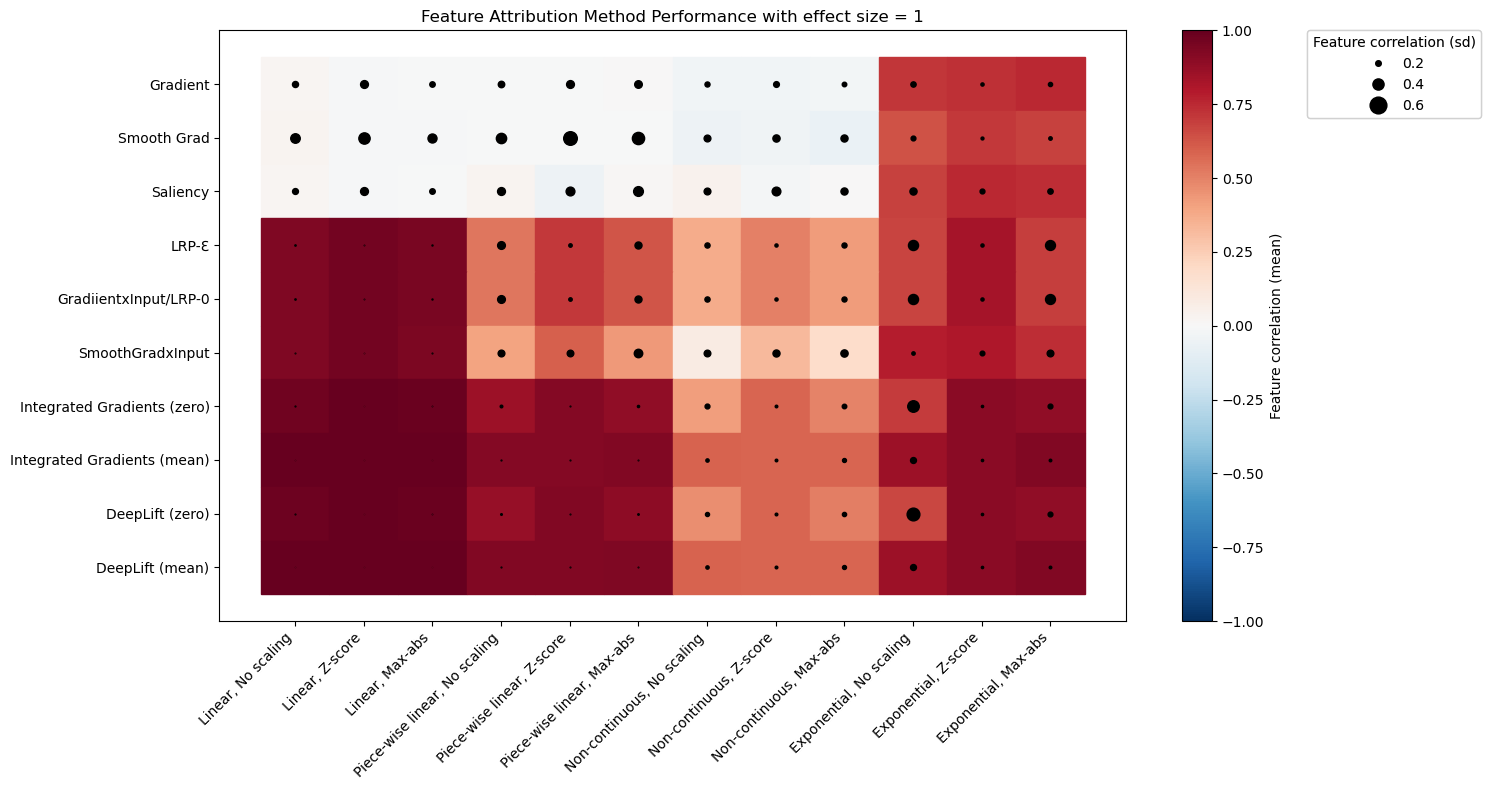

In [14]:

mean_df = pd.DataFrame(mean_vals, index=methods, columns=preprocessing)
std_df = pd.DataFrame(std_vals, index=methods, columns=preprocessing)

fig, ax = plt.subplots(figsize=(15, 8))

cmap = plt.cm.RdBu_r
norm = plt.Normalize(-1, 1)

for i, row in enumerate(mean_df.index):
    for j, col in enumerate(mean_df.columns):
        val = mean_df.loc[row, col]
        std = std_df.loc[row, col]

        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=cmap(norm(val))))

        ax.plot(j + 0.5, i + 0.5, 'ko', markersize=std * 20)

ax.set_xticks(np.arange(len(mean_df.columns)) + 0.5)
ax.set_xticklabels(mean_df.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(mean_df.index)) + 0.5)
ax.set_yticklabels(mean_df.index)
ax.invert_yaxis()


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Feature correlation (mean)')

std_legend_vals = [0.2, 0.4, 0.6]
dot_handles = [
    plt.plot([], [], 'ko', markersize=val * 20, label=f'{val:.1f}')[0]
    for val in std_legend_vals
]
std_legend = ax.legend(handles=dot_handles, title='Feature correlation (sd)',
                       loc='upper left', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
fig.add_artist(std_legend)

plt.title('Feature Attribution Method Performance with effect size = 1')
plt.tight_layout()
plt.show()

#### Plot the results of the simulation without the exponetial function

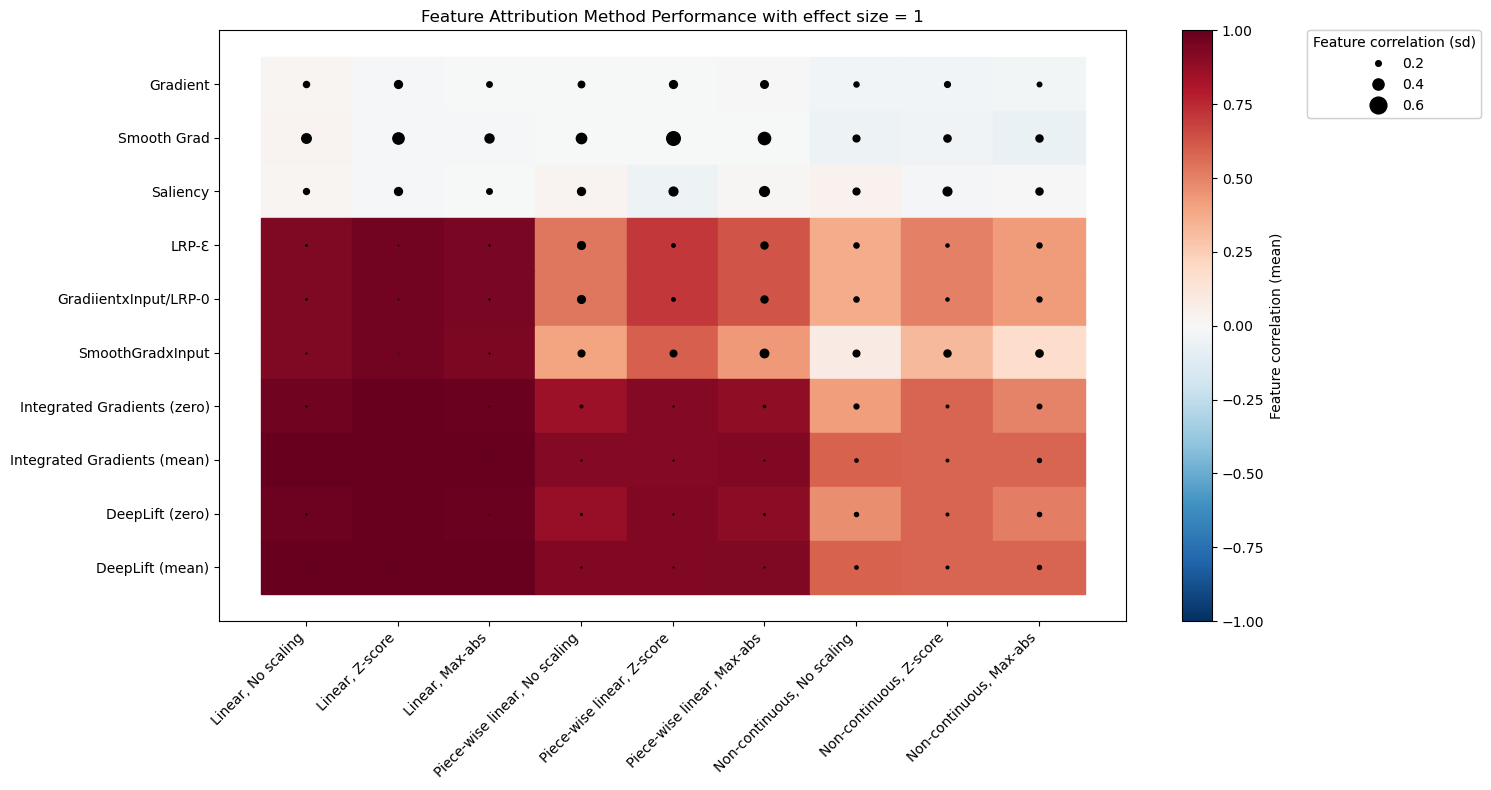

In [15]:
mean_vals2 = mean_vals[:,0:9]
std_vals2 = std_vals[:, 0:9]

mean_df2 = pd.DataFrame(mean_vals2, index=methods, columns=preprocessing[0:9])
std_df2 = pd.DataFrame(std_vals2, index=methods, columns=preprocessing[0:9])

fig, ax = plt.subplots(figsize=(15, 8))

# Create a color map background
cmap = plt.cm.RdBu_r  # red-blue colormap (reversed)
norm = plt.Normalize(-1, 1)  # normalize to your value range

for i, row in enumerate(mean_df2.index):
    for j, col in enumerate(mean_df2.columns):
        val = mean_df2.loc[row, col]
        std = std_df2.loc[row, col]

        # Plot color background
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=cmap(norm(val))))

        # Plot dot for std
        ax.plot(j + 0.5, i + 0.5, 'ko', markersize=std * 20)  # scale dot size

# Aesthetics
ax.set_xticks(np.arange(len(mean_df2.columns)) + 0.5)
ax.set_xticklabels(mean_df2.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(mean_df2.index)) + 0.5)
ax.set_yticklabels(mean_df2.index)
ax.invert_yaxis()

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Feature correlation (mean)')

# Legend for std (dot sizes)
std_legend_vals = [0.2, 0.4, 0.6]
dot_handles = [
    plt.plot([], [], 'ko', markersize=val * 20, label=f'{val:.1f}')[0]
    for val in std_legend_vals
]
std_legend = ax.legend(handles=dot_handles, title='Feature correlation (sd)',
                       loc='upper left', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
fig.add_artist(std_legend)

plt.title('Feature Attribution Method Performance with effect size = 1')
plt.tight_layout()
plt.show()